In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rp2
from rp2 import hagai_2018, create_folder, data, notebooks
from rp2.paths import get_output_path

_ = notebooks.initialise_environment(
    "Export_Counts",
    dependencies=["Burst_Model_Fitting"],
)

In [2]:
mouse_gene_info_df = rp2.load_biomart_gene_symbols_df("mouse").join(rp2.load_one_to_one_mouse_orthologues())
mouse_gene_info_df["symbol"] = mouse_gene_info_df["symbol"].str.lower()

output_path = get_output_path("Exported_Counts")


def load_gene_list(csv_path, column="symbol"):
    df = pd.read_csv(csv_path)
    return df[column].values


def load_rp2_analysis_genes(subset=False):
    df = data.load_rp2_analysis_genes()
    if subset:
        df = df.loc[df.in_subset]
    return df.index.to_list()


def mouse_gene_to_id(gene):
    if gene.startswith("ENSMUSG"):
        return gene

    df = mouse_gene_info_df.loc[mouse_gene_info_df.symbol == gene.lower()]
    if len(df) == 0:
        print(f"WARNING: unknown gene '{gene}' will be skipped")
        return np.nan
    elif len(df) > 1:
        print(f"WARNING: multiple genes with symbol '{gene}':")
        for id in df.index:
            print(f"    {id}")
        print(f"  Will use {df.index[0]}")




    return df.index[0]

## Export expression counts from Hagai *et al.* (2018) dataset

To export RNA counts for specific genes and conditions:
1. Ensure all previous cells have been executed
2. Edit the values of export_conditions (and show_histograms) accordingly in the cell below
3. Run the cell below

Output files will be created in *Output/Exported_Counts*.

Note that it is possible to combine conditions (i.e. replicate, treatment and time_point) by creating a list of lists. For example
```python
replicate = [["1", "2"], "3"]
```
will create results with replicates 1 and 2 combined and 3 as a separate condition.

For bulk exporting, a list of genes (IDs or symbols) can be loaded from a .csv file as follows:

```python
mouse_genes = load_gene_list("path/to/some/file.csv", column="symbol)
```

Alternatively, RP2 analysis genes may be used:

```python
mouse_genes = load_rp2_analysis_genes(subset=True)
```

Loading mouse "median" counts
File: mouse_median_ccl2_replicate_1_treatment_unst_lps_time_point_0.txt
  2,126 samples


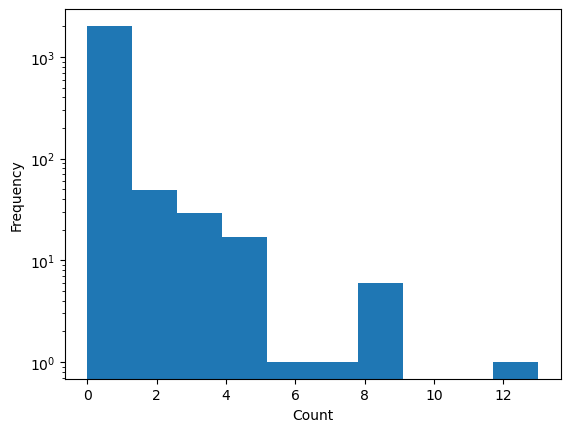

File: mouse_median_ccl2_replicate_1_treatment_unst_lps_time_point_2.txt
  2,537 samples


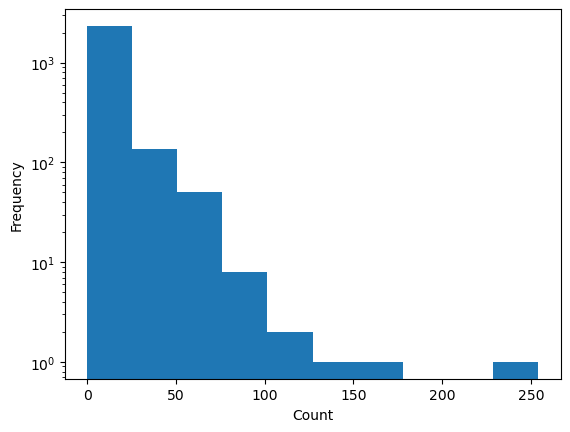

File: mouse_median_ccl2_replicate_1_treatment_unst_lps_time_point_4.txt
  2,366 samples


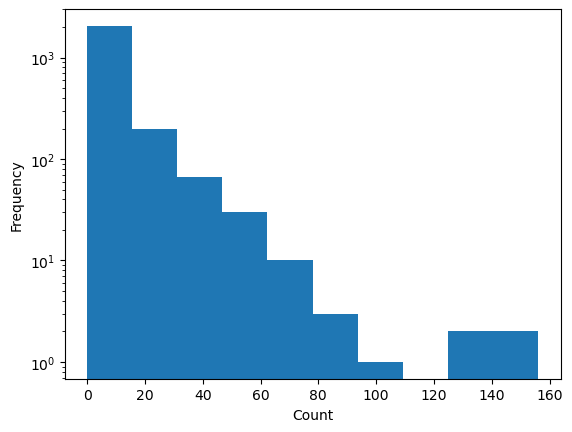

File: mouse_median_ccl2_replicate_1_treatment_unst_lps_time_point_6.txt
  1,703 samples


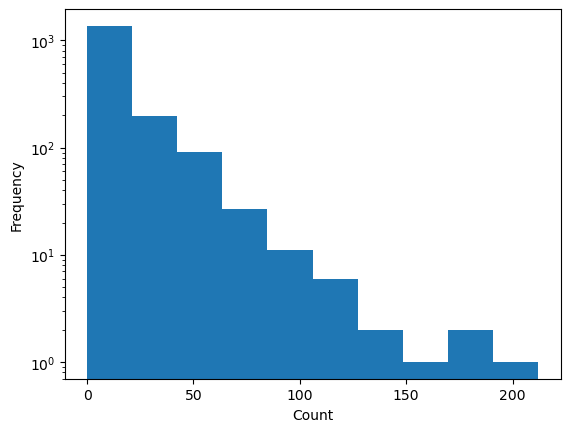

File: mouse_median_ccl2_replicate_1_treatment_unst_pic_time_point_0.txt
  2,126 samples


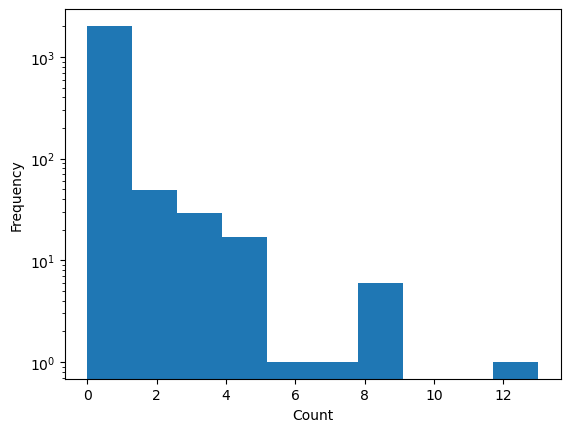

File: mouse_median_ccl2_replicate_1_treatment_unst_pic_time_point_2.txt
  3,025 samples


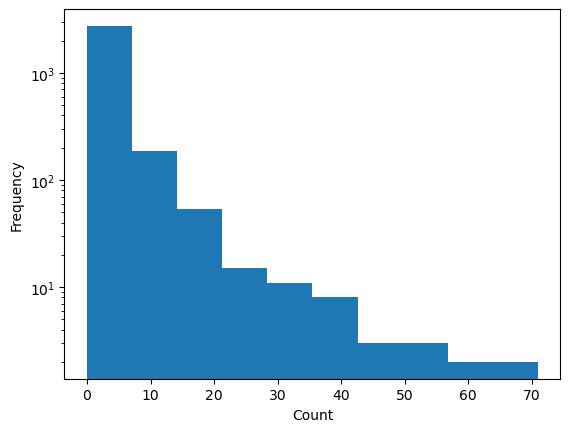

File: mouse_median_ccl2_replicate_1_treatment_unst_pic_time_point_4.txt
  2,394 samples


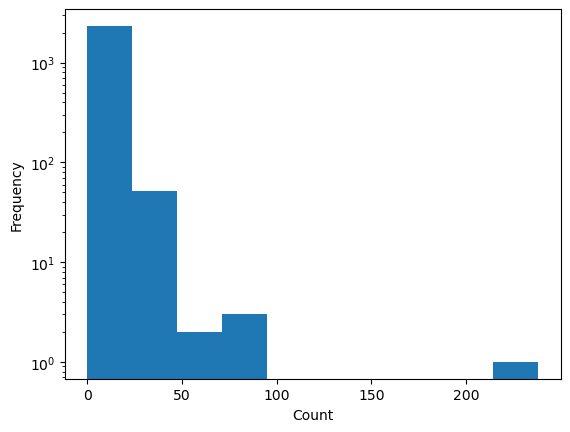

File: mouse_median_ccl2_replicate_1_treatment_unst_pic_time_point_6.txt
  0 samples
File: mouse_median_ccl2_replicate_2_treatment_unst_lps_time_point_0.txt
  3,519 samples


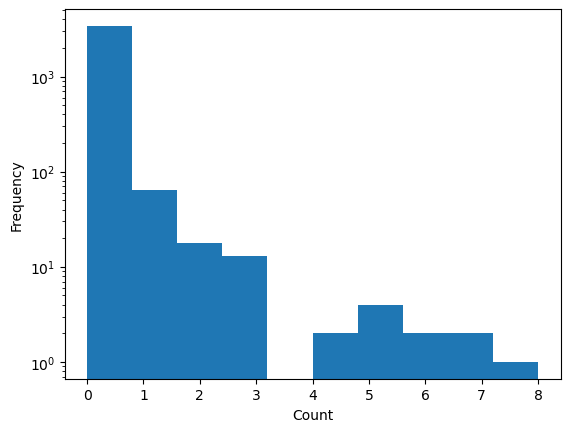

File: mouse_median_ccl2_replicate_2_treatment_unst_lps_time_point_2.txt
  4,321 samples


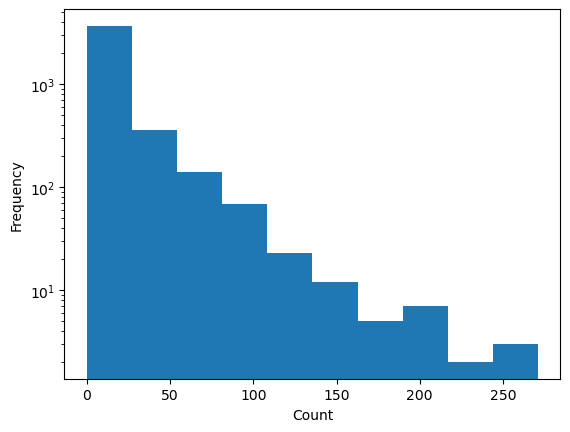

File: mouse_median_ccl2_replicate_2_treatment_unst_lps_time_point_4.txt
  3,293 samples


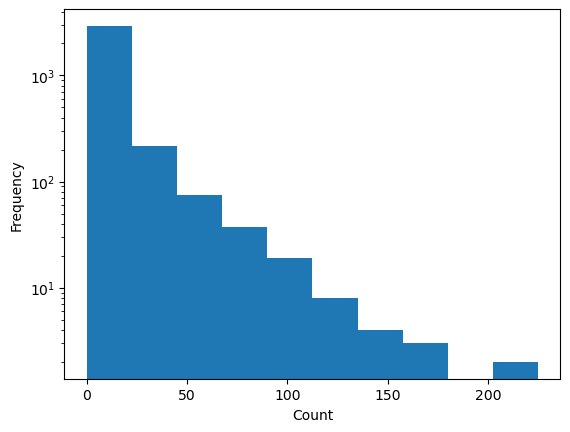

File: mouse_median_ccl2_replicate_2_treatment_unst_lps_time_point_6.txt
  2,126 samples


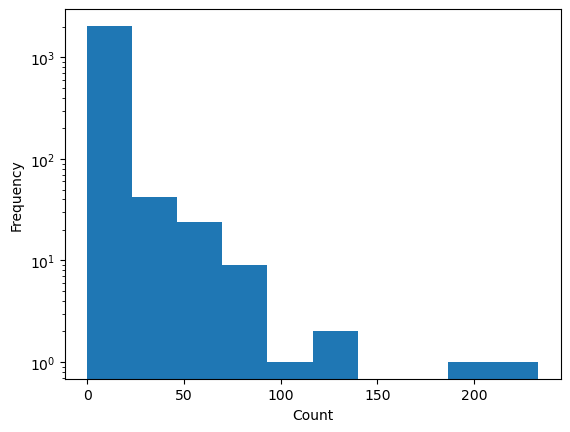

File: mouse_median_ccl2_replicate_2_treatment_unst_pic_time_point_0.txt
  3,519 samples


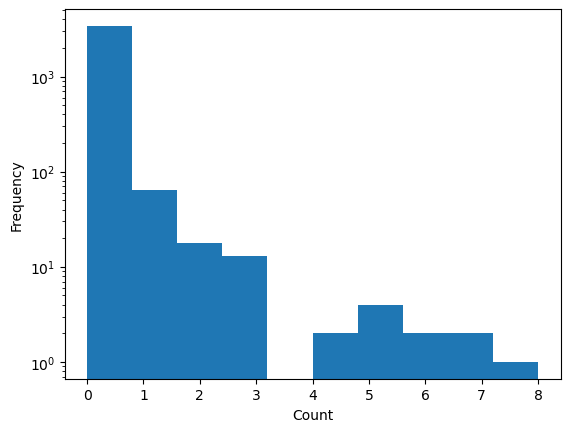

File: mouse_median_ccl2_replicate_2_treatment_unst_pic_time_point_2.txt
  3,322 samples


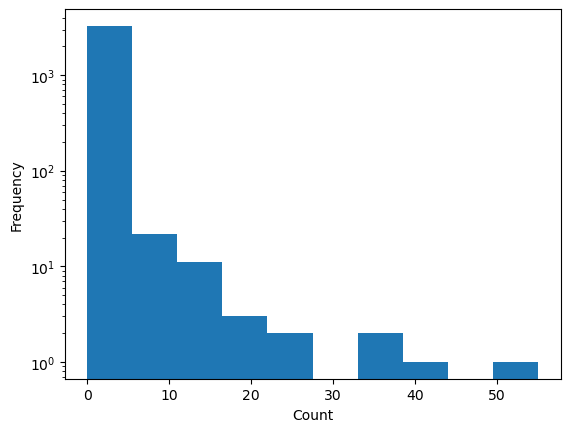

File: mouse_median_ccl2_replicate_2_treatment_unst_pic_time_point_4.txt
  2,718 samples


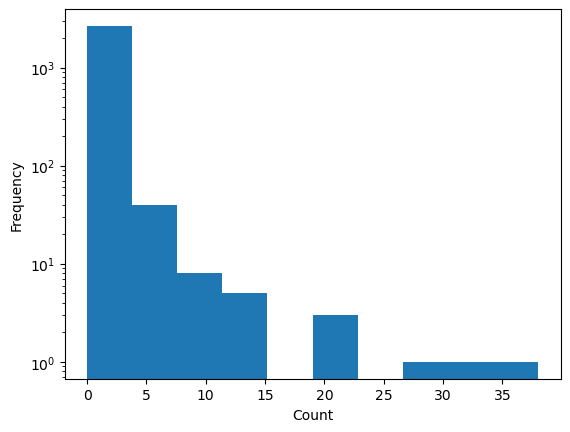

File: mouse_median_ccl2_replicate_2_treatment_unst_pic_time_point_6.txt
  2,775 samples


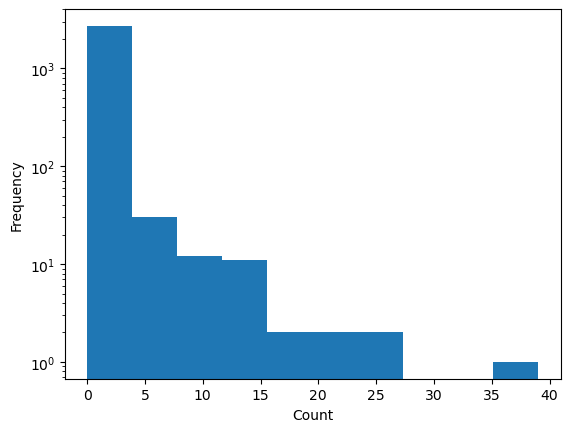

File: mouse_median_ccl2_replicate_3_treatment_unst_lps_time_point_0.txt
  2,936 samples


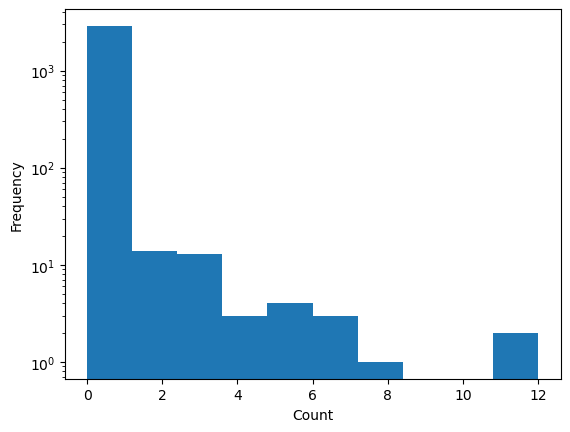

File: mouse_median_ccl2_replicate_3_treatment_unst_lps_time_point_2.txt
  3,169 samples


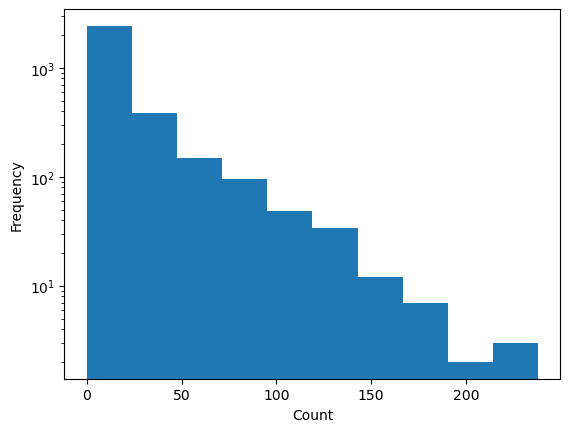

File: mouse_median_ccl2_replicate_3_treatment_unst_lps_time_point_4.txt
  3,536 samples


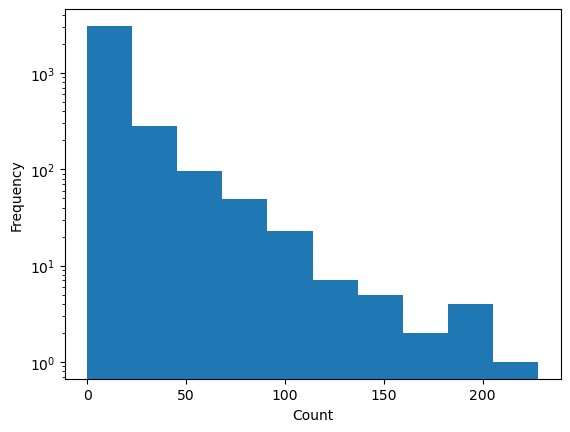

File: mouse_median_ccl2_replicate_3_treatment_unst_lps_time_point_6.txt
  1,453 samples


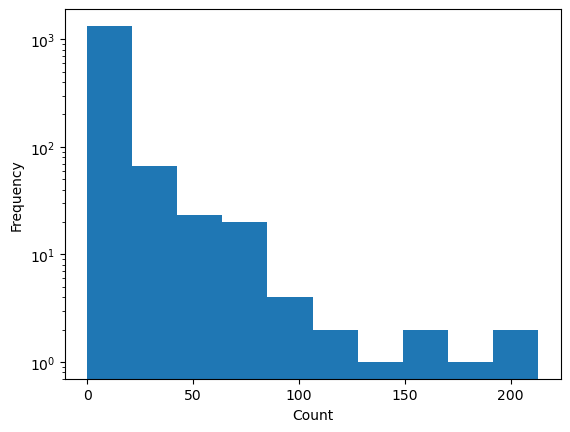

File: mouse_median_ccl2_replicate_3_treatment_unst_pic_time_point_0.txt
  2,936 samples


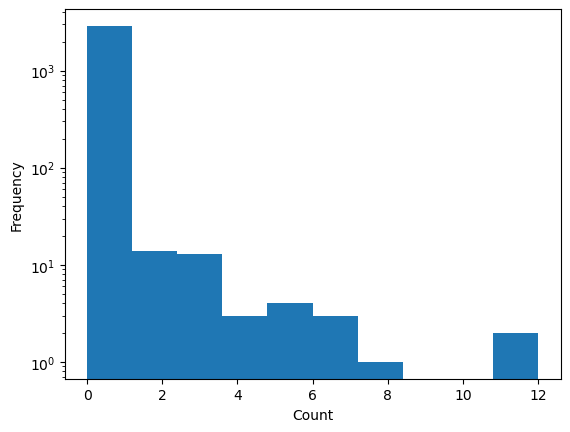

File: mouse_median_ccl2_replicate_3_treatment_unst_pic_time_point_2.txt
  2,760 samples


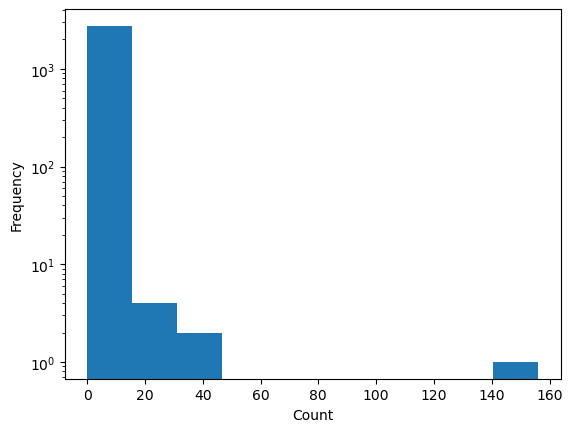

File: mouse_median_ccl2_replicate_3_treatment_unst_pic_time_point_4.txt
  1,403 samples


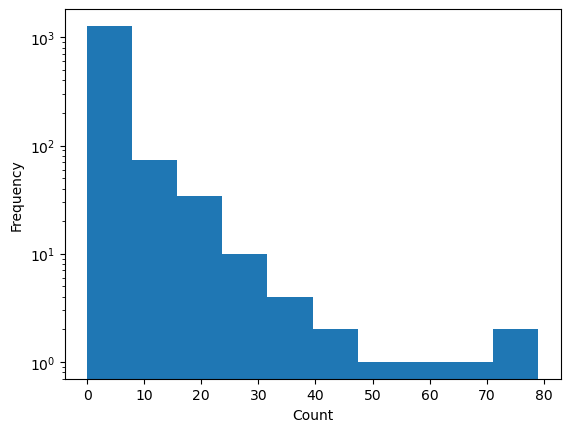

File: mouse_median_ccl2_replicate_3_treatment_unst_pic_time_point_6.txt
  1,604 samples


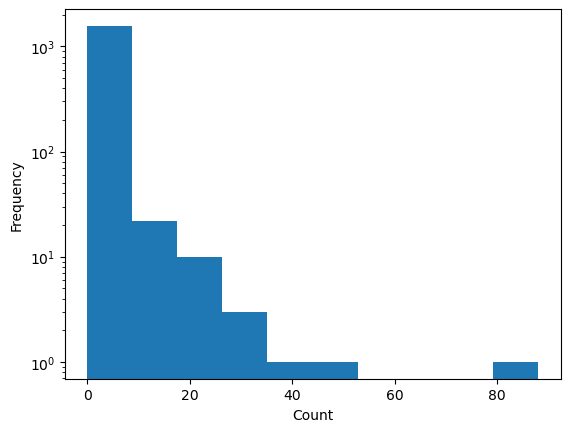

Finished


In [4]:
export_conditions = dict(
    species=["mouse"],
    count_type=["median"],  # Choose from umi, cpt, cpm or median
    mouse_genes=["ccl2"], #Sepcify genes
    replicate=["1", "2", "3"],
    treatment=[["unst", "lps"], ["unst", "pic"]],
    time_point=["0", "2", "4", "6"],
)

clean_output = False
show_histograms = True


create_folder(output_path, create_clean=clean_output)

count_adata_map = {}

export_conditions["mouse_genes"] = list(filter(lambda id: id is not np.nan, map(mouse_gene_to_id, export_conditions["mouse_genes"])))

for values in itertools.product(*export_conditions.values()):
    export_dict = dict(zip(export_conditions.keys(), values))

    species = export_dict.pop("species")
    count_type = export_dict.pop("count_type")
    mouse_gene_id = export_dict.pop("mouse_genes")
    mouse_gene_symbol = mouse_gene_info_df.loc[mouse_gene_id, "symbol"]

    species_gene_id = mouse_gene_id if species == "mouse" else mouse_gene_info_df.loc[mouse_gene_id, f"{species}_gene"]
    if species_gene_id is np.nan:
        print(f"WARNING: {species} has no orthologue for '{mouse_gene_symbol}'")
        continue

    count_key = f"{species}-{count_type}"
    if count_key in count_adata_map:
        count_adata = count_adata_map[count_key]
    else:
        print(f'Loading {species} "{count_type}" counts')
        count_adata = hagai_2018.load_counts(species, scaling=count_type)
        count_adata_map[count_key] = count_adata

    count_adata = count_adata[:, species_gene_id]

    filename = f"{species}_{count_type}_{mouse_gene_symbol}"

    for k, v in export_dict.items():
        if not isinstance(v, list):
            v = [v]
        count_adata = count_adata[count_adata.obs[k].isin(v), :]

        filename += f"_{k}_" + "_".join(v)

    filename += ".txt"

    print(f"File: {filename}")
    print(f"  {len(count_adata):,} samples")

    counts = np.asarray(count_adata.X.A).squeeze().round().astype(int)
    np.savetxt(output_path.joinpath(filename), counts, fmt="%d")

    if show_histograms and (len(counts) > 0):
        plt.hist(counts, log=True)
        plt.xlabel("Count")
        plt.ylabel("Frequency")
        plt.show()

print("Finished")